
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |    9 (0.29% of all)    |        200        |  0   | 0.658 ± 0.05 |
+---------+-------------------+---------------------------+--------------+------------+
| Methods | number_of_queries | number_of_different_split | performance  | batch_size |
+---------+-------------------+---------------------------+--------------+------------+
|  QUIRE  |        200        |             1             | 0.658 ± 0.00 |     1      |
+---------+-------------------+---------------------------+--------------+------------+


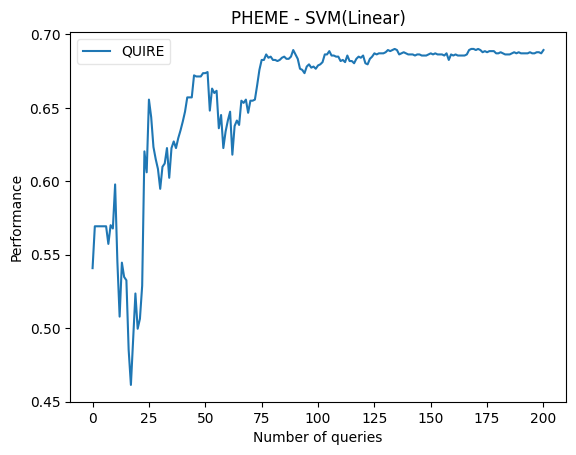

程序运行了108331.73222231865秒


In [1]:
import copy
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.svm import LinearSVC
import warnings
from alipy import ToolBox
warnings.filterwarnings("ignore")    #忽略警告

# X, y = make_classification(n_samples=500, n_features=10, n_informative=5, n_redundant=2,
#                            n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0,
#                            hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)


with open(
    "../../PHEME.json",
    "r",
) as file:
    data = json.load(file)
features = []
labels = []

for entry in data:
    feature = entry["feature"]
    label = int(entry["label"])
    features.append(feature)
    labels.append(label)

# 创建数据集
dataset = pd.DataFrame(features)
dataset["label"] = labels
X = dataset.drop("label", axis=1)
y = dataset["label"]
# 特征正则化处理

features_to_normalize = [
    "Length_of_Characters",
    "Number_of_Words",
    "User_Registration_Age",
    "Number_Of_Followers",
    "Statuses_Count",
    "Number_Of_Friends",
]
scaler = MinMaxScaler()
X[features_to_normalize] = scaler.fit_transform(X[features_to_normalize])
# scaler = Normalizer()
X_scaled = scaler.fit_transform(X)
y = np.array(y)
# 准备数据集，假设您的特征数据保存在X变量中，目标变量保存在y变量中
X = np.array(X)  # 特征数据


alibox = ToolBox(X=X, y=y, query_type="AllLabels", saving_path="./")

# Split data
alibox.split_AL(
    test_ratio=0.3, initial_label_rate=0.003, split_count=10, all_class=True
)

# Use the default Logistic Regression classifier
# model = alibox.get_default_model()
model = LinearSVC()

# The cost budget is 50 times querying
stopping_criterion = alibox.get_stopping_criterion("num_of_queries", 200)

# Use pre-defined strategy
#uncertainStrategy = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty",measure="entropy")
unc_result = []

start = time.time()

for round_exp in range(1):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round_exp)
    # Get intermediate results saver for one fold experiment
    saver = alibox.get_stateio(round_exp)
    
    model = LinearSVC()

    # Set initial performance point
    model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
    pred = model.predict(X[test_idx, :])
    accuracy = alibox.calc_performance_metric(
        y_true=y[test_idx], y_pred=pred, performance_metric="accuracy_score"
    )
    saver.set_initial_point(accuracy)
    uncertainStrategy = alibox.get_query_strategy(
        strategy_name="QueryInstanceQUIRE", train_idx=train_idx
    )

    while not stopping_criterion.is_stop():
        # Select a subset of Uind according to the query strategy
        # Passing any sklearn models with proba_predict method are ok
        select_ind = uncertainStrategy.select(
            label_ind, unlab_ind, model=model, batch_size=1
        )
        # or pass your proba predict result
        # prob_pred = model.predict_proba(x[unlab_ind])
        #select_ind = uncertainStrategy.select_by_prediction_mat(unlabel_index=unlab_ind, predict=prob_pred, batch_size=1)

        label_ind.update(select_ind)
        unlab_ind.difference_update(select_ind)

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(
            y_true=y[test_idx], y_pred=pred, performance_metric="accuracy_score"
        )

        # Save intermediate results to file
        st = alibox.State(select_index=select_ind, performance=accuracy)
        saver.add_state(st)
        saver.save()

        # Passing the current progress to stopping criterion object
        stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    stopping_criterion.reset()
    unc_result.append(copy.deepcopy(saver))

analyser = alibox.get_experiment_analyser(x_axis="num_of_queries")
analyser.add_method(method_name="QUIRE", method_results=unc_result)

print(analyser)
analyser.plot_learning_curves(
    title="PHEME - SVM(Linear)", std_area=False, saving_path="./"
)
end = time.time()
print("程序运行了{}秒".format(end - start))